# Dynamic Thermal Modeling of a Building
**Smart Cities**
Léo Couallier, Mathieu Coton, Aubin de Saint-Exupéry, Léopold Dupuy

This notebook develops a thermal model of a simplified building using the RC-network approach. The final goal is to extract a state-space model suitable for simulations.

Here is the link of our GitHub : https://github.com/cotonm/Smart-Cities-Labwork.git

## Import Required Packages

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image, display
from PIL import Image as PILImage
import pandas as pd

import dm4bem


# 1 - Modelling

## 1.1 Objectives
- Draw the plan of a two-zone building.
- Formulate the hypothesis for boundary conditions.
- Choose the types of windows, doors, and walls.
- Draw the thermal circuit:
temperature nodes,
flow-rate paths,
thermal conductances for conduction, convection, long-wave radiation, advection, and P-controllers,
sources of temperature and flow-rate,
- Number the temperature nodes and the flow-rate branches (starting from 0).
- Calculate the thermal conductances for conduction, convection, long-wave radiation, and advection.
- Calculate the thermal capacities.
- Write down the incidence matrix
A
, the conductance matrix
G
 and the capacity matrix
C
 of the system of Algebraic Differential Equations (DAE).
- Define the inputs: temperature sources (vector
b
) and flow rate sources (vector
f
).
- Write in Python the incidence matrix
A
, the conductance matrix
G
 and the capacity matrix
C
 of the system of Algebraic Differential Equations (DAE).
- Write in Python the vectors of pointers to the temperature sources
b
, flow-rate sources
f
, and outputs
y
.

## 1.2 Model of the two zone building

![Simple ventilated room](../Images/Figure1.png)

Figure 1. Simple ventilated room (5 walls, 1 glass window, 2 doors) equipped with two 2350W radiators.

**Description of the building**

In [4]:
#Left room (1)

l1 = 4             # m width of building
L1 = 5            # m length of building
S1 = 20           # m² surface area of room
h = 2.5           # Height of walls
Sd1 = 0.8*2       # m2 door surface (2m height)
Swindow = 1.5     # m2 window surface
Sw1 = 2*l1*h + 2*L1*h - Sd1 - Swindow     # m² inside surface area of concrete walls

#Right room (2)

l2 = 5            # m width of building
L2 = 5            # m length of building
S2 = 25           # m² surface area of room
h = 2.5           # Height of walls
Sd2 = 2*0.8*2      # m2 door surface
Sw2 = 2*l2*h + 2*L2*h - Sd2      # m² inside surface area of concrete walls

#Exterior (3)

Swe = 2*9*h + 2*5*h - Sd2 - Swindow #m2 exterior wall surface


## 1.3 Hypothesis of boundaries

The building has a rectangular shape, with the following thermal boundary conditions:

- East wall: adiabatic (no heat exchange).
- West wall: adiabatic.
- South wall: adiabatic.
- Only the North wall is in contact with the exterior environment and allows heat exchange.
- The ceiling and floor are also considered adiabatic, as a simplifying assumption.
- We consider the heat variation inside is uniform.

We consider the system in steady state, meaning that all temperatures are constant over time:
$\frac{dT_i}{dt} = 0 $

The heat transfer is assumed to be uniform across the entire surface of each wall. This implies that the heat flux is the same at every point on the surface. Therefore, the total heat flux through the wall can be written as:
$\dot{Q} = \frac{T_{\text{int}} - T_{\text{ext}}}{R_{\text{total}}} $


In [5]:
#Thermal Boundaries and properties

Text = 12    # °C Constant exterior temperature
Pr = 2350    # W Thermal power of each radiator


## 1.4 Thermo-physical properties

In [6]:
e_wall = 0.2    # m Concrete Width
e_d = 0.07    # m Wooden door width
e_window = 0.02 #m Glass window width


air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [7]:
import pandas as pd

# Hypothèse : ces variables sont définies ailleurs
# Sw1, Sw2, Swe, Swindow, Sd1, Sd2 = ...

# Material properties
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface_interior': Sw1 + Sw2,
            'Surface_exterior': Swe}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.02,
         'Surface_interior': Swindow,
         'Surface_exterior': Swindow}

wood = {'Conductivity': 0.12,
        'Density': 600.0,
        'Specific heat': 1600,
        'Width': 0.07,
        'Surface_interior': Sd1 + Sd2,
        'Surface_exterior': Sd2}

# Combine selected materials into a DataFrame
wall = pd.DataFrame([concrete, glass, wood],
                    index=['Concrete', 'Glass', 'Wood'])

# Display the DataFrame
wall



,Conductivity,Density,Specific heat,Width,Surface_interior,Surface_exterior
Concrete,1.40,2300.0,880,0.20,88.7,65.3
Glass,1.40,2500.0,1210,0.02,1.5,1.5
Wood,0.12,600.0,1600,0.07,4.8,3.2


**Radiative properties**

In [8]:
# Radiative properties (long-wave and short-wave)

# Long-wave emissivity (infrared)
ε_wall_LW = 0.85    # Wall surface (e.g. concrete, insulation)
ε_glass_LW = 0.90   # Glass (e.g. Pyrex or reflective)

# Short-wave absorptivity (solar)
α_wall_SW = 0.25    # Wall surface (e.g. white paint or concrete)
α_glass_SW = 0.38   # Reflective blue glass
α_wood_SW = 0.65    # Wood (e.g. medium-brown varnish, typical range 0.6–0.7)

# Short-wave transmittance (only glass transmits)
τ_glass_SW = 0.30   # Reflective blue glass

# Optional (if needed)
# ρ_glass_SW = 1 - α_glass_SW - τ_glass_SW  # reflectance (if useful)

**The Stefan-Boltzmann constant is**:

In [9]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

In [10]:
import pandas as pd

# Example convection coefficients
h_in = 8      # W/(m²·K) - interior surfaces
h_out = 25    # W/(m²·K) - exterior surfaces

# Create DataFrame with λ and h values (without Insulation)
thermal_properties = pd.DataFrame([
    {
        'Material': 'Concrete',
        'Conductivity λ [W/m·K]': 1.400,
        'h_in [W/m²·K]': h_in,
        'h_out [W/m²·K]': h_out
    },
    {
        'Material': 'Glass',
        'Conductivity λ [W/m·K]': 1.400,
        'h_in [W/m²·K]': h_in,
        'h_out [W/m²·K]': h_out
    },
    {
        'Material': 'Wood',
        'Conductivity λ [W/m·K]': 0.12,
        'h_in [W/m²·K]': h_in,
        'h_out [W/m²·K]': h_out
    }
])

# Set 'Material' as index
thermal_properties.set_index('Material', inplace=True)

# Display the table
thermal_properties


,Conductivity λ [W/m·K],h_in [W/m²·K],h_out [W/m²·K]
Material,,,
Concrete,1.40,8,25
Glass,1.40,8,25
Wood,0.12,8,25


The conductive and convection coefficients are:

In [11]:
import pandas as pd

# Geometry and areas (recomputed for clarity)
h = 2.5
l1, L1 = 4, 5
l2, L2 = 5, 5
Swindow = 1.5
Sd1 = 0.8 * h
Sd2 = 2 * 0.8 * h
Sw1 = 2 * l1 * h + 2 * L1 * h - Sd1 - Swindow
Sw2 = 2 * l2 * h + 2 * L2 * h - Sd2
Swe = 2 * 9 * h + 2 * 5 * h - Sd2 - Swindow

# Convection coefficients
h_in = 8      # W/(m²·K)
h_out = 25    # W/(m²·K)

# Material properties and areas (without Insulation)
materials = {
    'Concrete': {
        'λ': 1.400, 'e': 0.2,
        'A_in': Sw1 + Sw2,
        'A_out': Swe
    },
    'Glass': {
        'λ': 1.4, 'e': 0.02,
        'A_in': Swindow,
        'A_out': Swindow
    },
    'Wood': {
        'λ': 0.12, 'e': 0.07,
        'A_in': Sd1 + Sd2,
        'A_out': Sd2
    }
}

# Calculate resistances
resistances = []
for mat, props in materials.items():
    A_in = props['A_in']
    A_out = props['A_out']
    R_cond = props['e'] / (props['λ'] * A_in)
    R_conv_in = 1 / (h_in * A_in)
    R_conv_out = 1 / (h_out * A_out) if A_out else None

    resistances.append({
        'Material': mat,
        'R_cond [K/W]': round(R_cond, 6),
        'R_conv,in [K/W]': round(R_conv_in, 6),
        'R_conv,out [K/W]': round(R_conv_out, 6) if R_conv_out else None
    })

# Create DataFrame
R_table = pd.DataFrame(resistances).set_index('Material')

# Display table
R_table


,R_cond [K/W],"R_conv,in [K/W]","R_conv,out [K/W]"
Material,,,
Concrete,0.001633,0.001429,0.000620
Glass,0.009524,0.083333,0.026667
Wood,0.097222,0.020833,0.010000


In [12]:
import pandas as pd

# Volume intérieur d'air (à adapter selon ton modèle)
V_air = 112.5  # m³ (ex : 9 m x 5 m x 2.5 m)

# Thermal properties for each material
thermal_data = {
    'Concrete': {
        'Density': 2300.0,        # kg/m³
        'Specific heat': 880,     # J/(kg·K)
        'Width': 0.2,             # m
        'Surface': Sw1 + Sw2      # m²
    },
    'Glass': {
        'Density': 2500,
        'Specific heat': 1210,
        'Width': 0.02,
        'Surface': Swindow
    },
    'Wood': {
        'Density': 600,
        'Specific heat': 1600,
        'Width': 0.07,
        'Surface': Sd1 + Sd2
    },
    'Air': {
        'Density': 1.2,
        'Specific heat': 1005,
        'Width': None,            # Pas applicable
        'Surface': None           # Pas applicable
    }
}

# Calculate thermal capacities
thermal_capacities = []
for material, props in thermal_data.items():
    rho = props['Density']
    cp = props['Specific heat']
    if material == 'Air':
        C = rho * cp * V_air
        thermal_capacities.append({
            'Material': material,
            'Density [kg/m³]': rho,
            'c_p [J/(kg·K)]': cp,
            'Volume [m³]': V_air,
            'Thermal Capacity C [J/K]': round(C, 2)
        })
    else:
        e = props['Width']
        S = props['Surface']
        C = rho * cp * S * e  # in J/K
        thermal_capacities.append({
            'Material': material,
            'Density [kg/m³]': rho,
            'c_p [J/(kg·K)]': cp,
            'Width [m]': e,
            'Surface [m²]': S,
            'Thermal Capacity C [J/K]': round(C, 2)
        })

# Convert to DataFrame
df_capacity = pd.DataFrame(thermal_capacities)
df_capacity.set_index('Material', inplace=True)

# Display
df_capacity


,Density [kg/m³],c_p [J/(kg·K)],Width [m],Surface [m²],Thermal Capacity C [J/K],Volume [m³]
Material,,,,,,
Concrete,2300.0,880,0.20,87.5,35420000.0,NaN
Glass,2500.0,1210,0.02,1.5,90750.0,NaN
Wood,600.0,1600,0.07,6.0,403200.0,NaN
Air,1.2,1005,NaN,NaN,135675.0,112.5


## 1.5 Thermal-Electric Equivalent Circuit
Bellow we can see the electric model of the heat exchanges in the two zone building.

![Electric Model of the two zone building](../Images/Figure2.png)

Figure2. Equivalent electric circuit of the heat exchanges in the building.

## 1.6 Matrices 

La Matrice A est:

In [13]:
import numpy as np

# --- 1) On construit A ---
#    shape = [n_branches, n_nodes]
n_branches = 17
n_nodes    = 11
A = np.zeros((n_branches, n_nodes), dtype=int)

# Branche 1 (B1) : convection ext. béton gauche, réservoir T0 → nœud 0
A[0, 0] = 1

# B2 : conduction béton 0 → 1
A[1, 0], A[1, 1] = -1, 1

# B3 : conduction béton 1 → 2
A[2, 1], A[2, 2] = -1, 1

# B4 : convection int. béton 2 → 3
A[3, 2], A[3, 3] = -1, 1

# B5 : vitrage, réservoir T0 → 3
A[4, 3] = 1

# B6 : thermostat gauche, réservoir Tint_left → 3
A[5, 3] = 1

# B7 : convection central gauche, 3 → 4
A[6, 3], A[6, 4] = -1,  1

# B8 : conduction cloison couche 1, 4 → 5
A[7, 4], A[7, 5] = -1,  1

# B9 : conduction cloison couche 2, 5 → 6
A[8, 5], A[8, 6] = -1,  1

# B10: convection central droite, 6 → 7
A[9, 6], A[9, 7] = -1,  1

# B11: porte intérieure, 4 → 7
A[10, 4], A[10, 7] = -1, 1

# B12: convection cloison droite, 7 → 8
A[11, 7], A[11, 8] = -1,  1

# B13: conduction béton 8 → 9
A[12, 8], A[12, 9] = -1,  1

# B14: conduction béton 9 → 10
A[13, 9], A[13, 10] = -1, 1

# B15: convection ext. béton droite, réservoir T0 → 10
A[14, 10] = 1

# B16: porte extérieure, réservoir T0 → 7
A[15, 7] = 1

# B17: thermostat droite, réservoir Tint_right → 7
A[16, 7] = 1

# --- 2) Vérification rapide ---
import pandas as pd
df = pd.DataFrame(
    A,
    index=[f"B{k+1}" for k in range(n_branches)],
    columns=[f"θ{j}"     for j in range(n_nodes)]
)
print(df)



     θ0  θ1  θ2  θ3  θ4  θ5  θ6  θ7  θ8  θ9  θ10
B1    1   0   0   0   0   0   0   0   0   0    0
B2   -1   1   0   0   0   0   0   0   0   0    0
B3    0  -1   1   0   0   0   0   0   0   0    0
B4    0   0  -1   1   0   0   0   0   0   0    0
B5    0   0   0   1   0   0   0   0   0   0    0
B6    0   0   0   1   0   0   0   0   0   0    0
B7    0   0   0  -1   1   0   0   0   0   0    0
B8    0   0   0   0  -1   1   0   0   0   0    0
B9    0   0   0   0   0  -1   1   0   0   0    0
B10   0   0   0   0   0   0  -1   1   0   0    0
B11   0   0   0   0  -1   0   0   1   0   0    0
B12   0   0   0   0   0   0   0  -1   1   0    0
B13   0   0   0   0   0   0   0   0  -1   1    0
B14   0   0   0   0   0   0   0   0   0  -1    1
B15   0   0   0   0   0   0   0   0   0   0    1
B16   0   0   0   0   0   0   0   1   0   0    0
B17   0   0   0   0   0   0   0   1   0   0    0


La Matrice G est:

In [14]:
import numpy as np
import pandas as pd

# Conductances par branche (avec portes en bois ≃ 10.286 W/K aux indices 10 et 15)
G_values = [
    1612.903,  # Branch 1 : convection extérieure béton
    612.333,   # Branch 2 : conduction béton
    612.333,   # Branch 3 : conduction béton
    699.790,   # Branch 4 : convection intérieure béton
    105.000,   # Branch 5 : conduction vitrage
    1e6,       # Branch 6 : thermostat (ideal)
    699.790,   # Branch 7 : convection intérieure béton
    10.286,    # Branch 8 : conduction bois (Sd1)
    10.286,    # Branch 9 : conduction bois (Sd2)
    699.790,   # Branch 10: convection intérieure béton
    10.286,    # Branch 11: conduction porte intérieure (bois)
    699.790,   # Branch 12: convection intérieure béton
    612.333,   # Branch 13: conduction béton
    612.333,   # Branch 14: conduction béton
    1612.903,  # Branch 15: convection extérieure béton
    10.286,    # Branch 16: conduction porte extérieure (bois)
    1e6        # Branch 17: thermostat (ideal)
]

# Construction de la matrice diagonale G
G = np.diag(G_values)

# (Optionnel) Affichage pour vérification
labels = [f"B{i+1}" for i in range(len(G_values))]
G_df = pd.DataFrame(G, index=labels, columns=labels)
print(G_df)


           B1       B2       B3      B4     B5         B6      B7      B8  \
B1   1612.903    0.000    0.000    0.00    0.0        0.0    0.00   0.000   
B2      0.000  612.333    0.000    0.00    0.0        0.0    0.00   0.000   
B3      0.000    0.000  612.333    0.00    0.0        0.0    0.00   0.000   
B4      0.000    0.000    0.000  699.79    0.0        0.0    0.00   0.000   
B5      0.000    0.000    0.000    0.00  105.0        0.0    0.00   0.000   
B6      0.000    0.000    0.000    0.00    0.0  1000000.0    0.00   0.000   
B7      0.000    0.000    0.000    0.00    0.0        0.0  699.79   0.000   
B8      0.000    0.000    0.000    0.00    0.0        0.0    0.00  10.286   
B9      0.000    0.000    0.000    0.00    0.0        0.0    0.00   0.000   
B10     0.000    0.000    0.000    0.00    0.0        0.0    0.00   0.000   
B11     0.000    0.000    0.000    0.00    0.0        0.0    0.00   0.000   
B12     0.000    0.000    0.000    0.00    0.0        0.0    0.00   0.000   

La Matrice C est:

In [15]:
import pandas as pd
import numpy as np

# Liste des capacités thermiques pour les 11 nœuds (Noeuds 0 à 10)
capacities = [
    0.0,        # Noeud 0
    35420000.0, # Noeud 1
    0.0,        # Noeud 2
    135675.0,   # Noeud 3
    0.0,        # Noeud 4
    35420000.0, # Noeud 5
    0.0,        # Noeud 6
    135675.0,   # Noeud 7
    0.0,        # Noeud 8
    35420000.0, # Noeud 9
    0.0         # Noeud 10
]

# Création de la matrice diagonale
C_matrix = np.diag(capacities)

# Création des labels de lignes et de colonnes
nodes = [f"Noeud_{i}" for i in range(11)]

# Création de la DataFrame
C = pd.DataFrame(C_matrix, index=nodes, columns=nodes)

# Affichage (facultatif)
print(C)


          Noeud_0     Noeud_1  Noeud_2   Noeud_3  Noeud_4     Noeud_5  \
Noeud_0       0.0         0.0      0.0       0.0      0.0         0.0   
Noeud_1       0.0  35420000.0      0.0       0.0      0.0         0.0   
Noeud_2       0.0         0.0      0.0       0.0      0.0         0.0   
Noeud_3       0.0         0.0      0.0  135675.0      0.0         0.0   
Noeud_4       0.0         0.0      0.0       0.0      0.0         0.0   
Noeud_5       0.0         0.0      0.0       0.0      0.0  35420000.0   
Noeud_6       0.0         0.0      0.0       0.0      0.0         0.0   
Noeud_7       0.0         0.0      0.0       0.0      0.0         0.0   
Noeud_8       0.0         0.0      0.0       0.0      0.0         0.0   
Noeud_9       0.0         0.0      0.0       0.0      0.0         0.0   
Noeud_10      0.0         0.0      0.0       0.0      0.0         0.0   

          Noeud_6   Noeud_7  Noeud_8     Noeud_9  Noeud_10  
Noeud_0       0.0       0.0      0.0         0.0       0.0  
N

In [16]:
import pandas as pd

# Définition des flux (branches thermiques)
q = range(1, 18)  # flux 1 à 17

# Vecteur b : sources de température par flux
b = pd.Series([
    'T0',     # flux 1
    0,        # flux 2
    0,        # flux 3
    0,        # flux 4
    'T0',     # flux 5
    'Tint_left',# flux 6
    0,        # flux 7
    0,        # flux 8
    0,        # flux 9
    0,        # flux 10
    0,        # flux 11
    0,        # flux 12
    0,        # flux 13
    0,        # flux 14
    'T0',     # flux 15
    'T0',     # flux 16
    'Tint_right'# flux 17
], index=q)

# Affichage propre en DataFrame
b_df = pd.DataFrame({'Flux': b.index, 'Source de température': b.values})
display(b_df)


,Flux,Source de température
0,1,T0
1,2,0
2,3,0
3,4,0
4,5,T0
5,6,Tint_left
6,7,0
7,8,0
8,9,0
9,10,0


In [17]:
import pandas as pd

# Liste des nœuds (températures)
θ = [f'T{i}' for i in range(1, 12)]  # T1 à T11

# Définir le vecteur f
f = pd.Series([
    'Φ0',        # T0 : mur extérieur gauche
    0,           # T1 : mur intérieur gauche
    'Qi',   # T2 : mur intérieur gauche
    'Q_point_a',           # T3 : air intérieur gauche
    'Φi',           # T4 : mur central droite
    0,  # T5 : air zone droite
    0,           # T6 : mur intérieur droite
    'Q_point_a',        # T7 : air intérieur droit
    0,   # T8 : vitrage gauche
    0,  # T9 : vitrage droite
    'Φ0'            # T10 : paroi extérieur droite
], index=θ)

# Affichage propre
f_df = pd.DataFrame({'Noeud (Température)': f.index, 'Source de chaleur': f.values})
display(f_df)


,Noeud (Température),Source de chaleur
0,T1,Φ0
1,T2,0
2,T3,Qi
3,T4,Q_point_a
4,T5,Φi
5,T6,0
6,T7,0
7,T8,Q_point_a
8,T9,0
9,T10,0


Températures régime permanent [°C] : [19.92209332 19.95104111]


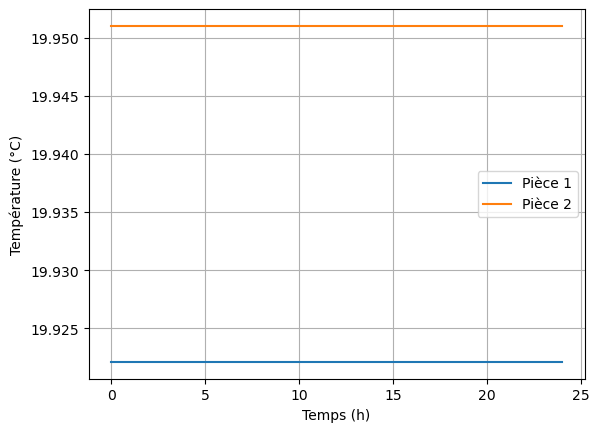

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# === 2) Propriétés & résistances thermiques ===
h_in, h_out = 8, 25

materials = {
    'Concrete': {'λ':1.4,  'e':0.2,  'A_in':Sw1+Sw2, 'A_out':Swe},
    'Glass':    {'λ':1.4,  'e':0.02, 'A_in':Swindow, 'A_out':Swindow},
    'Wood':     {'λ':0.12, 'e':0.07, 'A_in':Sd1+Sd2,  'A_out':Sd2}
}

# calcul R_cond, R_conv_in, R_conv_out
R = {}
for m,p in materials.items():
    A_in, A_out = p['A_in'], p['A_out']
    R[m] = {
        'R_cond':    p['e'] / (p['λ'] * A_in),
        'R_conv_in': 1/(h_in  * A_in),
        'R_conv_out': 1/(h_out * A_out) if A_out else np.inf
    }

# === 3) Conductances G_values (17 branches) ===
G_conv_out_conc = 1/ R['Concrete']['R_conv_out']
G_cond_conc     = 1/ R['Concrete']['R_cond']
G_conv_in_conc  = 1/ R['Concrete']['R_conv_in']
G_cond_glass    = 1/ R['Glass']['R_cond']
G_wood          = 1/ R['Wood']['R_cond']
G_thermo        = 1e6

G_values = np.array([
    G_conv_out_conc,  # B1
    G_cond_conc,      # B2
    G_cond_conc,      # B3
    G_conv_in_conc,   # B4
    G_cond_glass,     # B5
    G_thermo,         # B6
    G_conv_in_conc,   # B7
    G_wood,           # B8
    G_wood,           # B9
    G_conv_in_conc,   # B10
    G_wood,           # B11 (porte int.)
    G_conv_in_conc,   # B12
    G_cond_conc,      # B13
    G_cond_conc,      # B14
    G_conv_out_conc,  # B15
    G_wood,           # B16 (porte ext.)
    G_thermo          # B17
])

# 4) Incidence H (2 nœuds d’air)
#   0 = pièce 1, 1 = pièce 2
branch_connections = [
    (0,None),(0,None),(0,None),(0,None),(0,None),(0,None),(0,None),
    (0,None),(0,None),(0,None),(0,1), (1,None),(1,None),(1,None),
    (1,None),(1,None),(1,None)
]
n_nodes, n_br = 2, len(G_values)
H = np.zeros((n_nodes, n_br))
for k,(i,j) in enumerate(branch_connections):
    H[i,k] =  1
    if j is not None:
        H[j,k] = -1

# 5) Matrice nodale des conductances Gn = H·diag(G)·Hᵀ
Gn = H @ np.diag(G_values) @ H.T

# 6) Capacités d’air Cn
rho_air, c_air = 1.225, 1005
V1, V2         = S1*h, S2*h
Cn             = np.diag([rho_air*c_air*V1, rho_air*c_air*V2])

# 7) Forçages
Text, Tint_left, Tint_right = 12, 20, 20   # °C
Pr = 2350                                 # W radiateur

b_forc = np.zeros((n_nodes,1))
# 7a) Couplage à la météo (branches extérieures : 0, 4 et 14)
for b in (0,4,14):
    node = branch_connections[b][0]
    b_forc[node,0] += G_values[b]*Text
# branche 16 (index 15) porte extérieure Pièce 2
b_forc[branch_connections[15][0],0] += G_values[15]*Text

# 7b) Thermostats (branches 6 et 17)
b_forc[0,0] += G_values[5] * Tint_left
b_forc[1,0] += G_values[16] * Tint_right

# 7c) Chauffage
f = np.array([[Pr],[Pr]])

# 8) Assemblage du DAE C·dT/dt = –Gn·T + b_forc + f
A_dae = -np.linalg.inv(Cn) @ Gn
B_dae = np.linalg.inv(Cn) @ (b_forc + f)

# 9) Régime permanent : Gn·T_ss = b_forc + f
T_ss = np.linalg.solve(Gn, b_forc + f).flatten()
print("Températures régime permanent [°C] :", T_ss)

# 10) Simulation dynamique (Euler implicite)
dt      = 600         # 10 min
t_final = 24*3600     # 24 h
n_steps = int(t_final/dt)
T       = np.zeros((n_steps+1, n_nodes))
T[0,:]  = T_ss
I       = np.eye(n_nodes)
M       = np.linalg.inv(I - dt*A_dae)
for k in range(n_steps):
    T[k+1,:] = (M @ (T[k].reshape(-1,1) + dt*B_dae)).flatten()

# 11) Affichage
time_h = np.arange(n_steps+1) * dt / 3600
plt.plot(time_h, T[:,0], label="Pièce 1")
plt.plot(time_h, T[:,1], label="Pièce 2")
plt.xlabel("Temps (h)")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import numpy as np

# 1) Temperature sources par branche (bss, length = n_branches)
n_br = A.shape[0]
bss = np.zeros(n_br)
# branches reliées à la température extérieure
for k in (0, 4, 14, 15):
    bss[k] = Text
# branches reliées aux consignes de thermostat
bss[5]  = Tint_left
bss[16] = Tint_right

# 2) Heat‐flow sources par nœud (fss, length = n_nodes)
n_nodes = A.shape[1]
fss     = np.zeros(n_nodes)
# nœuds intérieurs air (d’après votre A) → indices 3 et 7
fss[3] = Pr   # radiateur pièce 1
fss[7] = Pr   # radiateur pièce 2

# 3) Assemblage de l’équation steady-state
diagG      = np.diag(G_values)            # diag(G)
lhs        = A.T @ diagG @ A             # Aᵀ·G·A   (11×11)
rhs        = A.T @ diagG @ bss + fss     # Aᵀ·G·b + f  (11,)
θss_all    = np.linalg.solve(lhs, rhs)    # résolution  (11,)

print("Températures steady-state de tous les nœuds :", np.round(θss_all,2), "°C")
print("→ T_air pièce 1 =", θss_all[3].round(2), "°C   |   T_air pièce 2 =", θss_all[7].round(2), "°C")



Températures steady-state de tous les nœuds : [12.93 15.39 17.85 20.   20.   20.   20.   20.   17.85 15.39 12.93] °C
→ T_air pièce 1 = 20.0 °C   |   T_air pièce 2 = 20.0 °C
